# Predicting Flight Delay Duration Using Machine Learning

## 2. Technical Setup and Utilities

### 2.1 Imports

In [2]:
# ============================================================
# 📦 Core Scientific Stack
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# 📊 Visualization
# ============================================================
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# ============================================================
# 📐 Statistics & Statistical Modeling
# ============================================================
import scipy.stats as stats
import statsmodels.api as sm

# ============================================================
# 🤖 Machine Learning — Core Utilities
# ============================================================
from sklearn.model_selection import (KFold, cross_val_score, GridSearchCV, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, PolynomialFeatures)
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)

# ============================================================
# 🧱 Preprocessing & Pipelines
# ============================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# ============================================================
# 📈 Linear & Regularized Models
# ============================================================
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV)

# ============================================================
# 🌳 Tree-Based Models
# ============================================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)

# ============================================================
# 🌊 Kernel-Based Models
# ============================================================
from sklearn.svm import SVR

# ============================================================
# 🚀 Gradient Boosting (External)
# ============================================================
from xgboost import XGBRegressor

# ============================================================
# 🚨 Anomaly Detection (used in EDA / preprocessing)
# ============================================================
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# ============================================================
# 🛠 Utilities & Configuration
# ============================================================
import os
import re
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# 🎨 Project Styling
# ============================================================
MAIN_COLOR = "#B388EB"
RANDOM_STATE = 1234

### 2.2  IQR-Based Outlier Handling Utilities

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, k=1.5):
        self.k = k

    def fit(self, X, y=None):
        # Ensure DataFrame for column-wise operations
        X = pd.DataFrame(X)

        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1

        self.lower_bounds_ = q1 - self.k * iqr
        self.upper_bounds_ = q3 + self.k * iqr

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in X.columns:
            X[col] = X[col].clip(
                lower=self.lower_bounds_[col],
                upper=self.upper_bounds_[col]
            )

        return X

## 3. Data Loading & Initial Exploration

### 3.1 Load Raw Datasets

In [5]:
# ----------------------------
# Load datasets
# ----------------------------

train_path = "../data/Zindi/Train.csv"
test_path = "../data/Zindi/Test.csv"

airports_path = "../data/airportsdata/airports.csv"
iata_macs_path = "../data/airportsdata/iata_macs.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

airports_df = pd.read_csv(airports_path)
iata_macs_df = pd.read_csv(iata_macs_path)


### 3.2 Basic Dataset Inspection

In [6]:

# ----------------------------
# Basic inspection
# ----------------------------

print("=== TRAIN ===")
print(train_df.shape)
display(train_df.info())
display(train_df.head())

print("\n=== TEST ===")
print(test_df.shape)
display(test_df.info())
display(test_df.head())

print("\n=== AIRPORTS ===")
print(airports_df.shape)
display(airports_df.info()) 
display(airports_df.head())

print("\n=== IATA MACS ===")
print(iata_macs_df.shape)
display(iata_macs_df.info())
display(iata_macs_df.head())


# ----------------------------
# Column overview
# ----------------------------

print("\nTrain columns:\n", train_df.columns.tolist())
print("\nTrain columns:\n", test_df.columns.tolist())
print("\nAirports columns:\n", airports_df.columns.tolist())
print("\nIATA MACS columns:\n", iata_macs_df.columns.tolist())


=== TRAIN ===
(107833, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


None

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0



=== TEST ===
(9333, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9333 entries, 0 to 9332
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      9333 non-null   object
 1   DATOP   9333 non-null   object
 2   FLTID   9333 non-null   object
 3   DEPSTN  9333 non-null   object
 4   ARRSTN  9333 non-null   object
 5   STD     9333 non-null   object
 6   STA     9333 non-null   object
 7   STATUS  9333 non-null   object
 8   AC      9333 non-null   object
dtypes: object(9)
memory usage: 656.4+ KB


None

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
0,test_id_0,2016-05-04,TU 0700,DJE,TUN,2016-05-04 06:40:00,2016-05-04 07.30.00,ATA,TU 32AIMF
1,test_id_1,2016-05-05,TU 0395,TUN,BKO,2016-05-05 15:20:00,2016-05-05 20.05.00,ATA,TU 320IMW
2,test_id_2,2016-05-06,TU 0745,FRA,TUN,2016-05-06 10:00:00,2016-05-06 12.25.00,ATA,TU 32AIMC
3,test_id_3,2016-05-11,TU 0848,BEY,TUN,2016-05-11 09:40:00,2016-05-11 13.10.00,ATA,TU 31BIMO
4,test_id_4,2016-05-11,TU 0635,ORY,MIR,2016-05-11 09:50:00,2016-05-11 12.35.00,ATA,TU 736IOQ



=== AIRPORTS ===
(28270, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28270 entries, 0 to 28269
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   icao       28270 non-null  object 
 1   iata       7859 non-null   object 
 2   name       28270 non-null  object 
 3   city       25440 non-null  object 
 4   subd       27497 non-null  object 
 5   country    28207 non-null  object 
 6   elevation  28270 non-null  float64
 7   lat        28270 non-null  float64
 8   lon        28270 non-null  float64
 9   tz         28270 non-null  object 
 10  lid        12610 non-null  object 
dtypes: float64(3), object(8)
memory usage: 2.4+ MB


None

,icao,iata,name,city,subd,country,elevation,lat,lon,tz,lid
0,00AA,NaN,Aero B Ranch Airport,Leoti,Kansas,US,3435.0,38.70402,-101.47391,America/Chicago,00AA
1,00AK,NaN,Lowell Field,Anchor Point,Alaska,US,252.0,59.94889,-151.69222,America/Anchorage,00AK
2,00AL,NaN,Epps Airpark,Harvest,Alabama,US,820.0,34.86481,-86.77028,America/Chicago,00AL
3,00AN,NaN,Katmai Lodge Airport,King Salmon,Alaska,US,80.0,59.09347,-156.45583,America/Anchorage,00AN
4,00AR,NaN,Arland Airport,Bennington,Kansas,US,1352.0,38.96965,-97.60156,America/Chicago,00AR



=== IATA MACS ===
(89, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country       89 non-null     object
 1   City Code     89 non-null     object
 2   City Name     89 non-null     object
 3   Airport Code  89 non-null     object
 4   Airport Name  89 non-null     object
dtypes: object(5)
memory usage: 3.6+ KB


None

,Country,City Code,City Name,Airport Code,Airport Name
0,AE,DXB,Dubai,DWC,Al Maktoum Intl
1,AE,DXB,Dubai,DXB,International
2,AR,BUE,Buenos Aires,AEP,Jorge Newbery
3,AR,BUE,Buenos Aires,EZE,Ministro Pistarini
4,AU,MEL,Melbourne,AVV,Avalon



Train columns:
 ['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC', 'target']

Train columns:
 ['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC']

Airports columns:
 ['icao', 'iata', 'name', 'city', 'subd', 'country', 'elevation', 'lat', 'lon', 'tz', 'lid']

IATA MACS columns:
 ['Country', 'City Code', 'City Name', 'Airport Code', 'Airport Name']


### 3.3 Unique Values & Airport Code Exploration

In [7]:
# ----------------------------
# Unique values in flight data
# ----------------------------

print("Unique DEPSTN airports:", train_df["DEPSTN"].nunique())
print("Unique ARRSTN airports:", train_df["ARRSTN"].nunique())

print("\nSample DEPSTN values:")
print(train_df["DEPSTN"].value_counts().head(10))

print("\nSample ARRSTN values:")
print(train_df["ARRSTN"].value_counts().head(10))


Unique DEPSTN airports: 132
Unique ARRSTN airports: 128

Sample DEPSTN values:
DEPSTN
TUN    42522
DJE    10252
ORY     6755
MIR     5248
MRS     2845
LYS     2358
NCE     2227
ALG     1573
MXP     1534
IST     1442
Name: count, dtype: int64

Sample ARRSTN values:
ARRSTN
TUN    42572
DJE    10198
ORY     6755
MIR     5251
MRS     2845
LYS     2359
NCE     2228
ALG     1573
MXP     1534
IST     1442
Name: count, dtype: int64


In [8]:
# ----------------------------
# Unique IATA airports
# ----------------------------

print("Unique IATA airports in airports dataset:", airports_df["iata"].nunique())

print("\nSample IATA values:")
print(airports_df["iata"].value_counts().head(10))


Unique IATA airports in airports dataset: 7859

Sample IATA values:
iata
OCA    1
SGL    1
MNL    1
DRP    1
LAO    1
CRK    1
SFS    1
ENI    1
OGN    1
RNJ    1
Name: count, dtype: int64


In [9]:
# ----------------------------
# Inspect Airport Code in iata_macs
# ----------------------------

print("Unique Airport Codes in iata_macs:",
      iata_macs_df["Airport Code"].nunique())

print("\nSample Airport Codes from iata_macs:")
print(iata_macs_df["Airport Code"].value_counts().head(10))


Unique Airport Codes in iata_macs: 89

Sample Airport Codes from iata_macs:
Airport Code
DWC    1
NGO    1
DKR    1
BMA    1
ARN    1
VKO    1
SVO    1
DME    1
TRF    1
OSL    1
Name: count, dtype: int64


### 3.4 Dataset Relationship & Join Feasibility Check

In [10]:
# ----------------------------
# Check matching coverage
# ----------------------------

dep_not_found = set(train_df["DEPSTN"]) - set(airports_df["iata"])
arr_not_found = set(train_df["ARRSTN"]) - set(airports_df["iata"])

print("DEPSTN not found in airports IATA:", len(dep_not_found))
print("ARRSTN not found in airports IATA:", len(arr_not_found))

print("\nSample missing DEPSTN:", list(dep_not_found)[:10])
print("Sample missing ARRSTN:", list(arr_not_found)[:10])

# ----------------------------
# Check matching coverage (TEST)
# ----------------------------

dep_not_found_test = set(test_df["DEPSTN"]) - set(airports_df["iata"])
arr_not_found_test = set(test_df["ARRSTN"]) - set(airports_df["iata"])

print("\n\nTEST DEPSTN not found in airports IATA:", len(dep_not_found_test))
print("TEST ARRSTN not found in airports IATA:", len(arr_not_found_test))

print("\nSample missing TEST DEPSTN:", list(dep_not_found_test)[:10])
print("Sample missing TEST ARRSTN:", list(arr_not_found_test)[:10])

DEPSTN not found in airports IATA: 1
ARRSTN not found in airports IATA: 1

Sample missing DEPSTN: ['SXF']
Sample missing ARRSTN: ['SXF']


TEST DEPSTN not found in airports IATA: 1
TEST ARRSTN not found in airports IATA: 1

Sample missing TEST DEPSTN: ['SXF']
Sample missing TEST ARRSTN: ['SXF']


In [11]:
dep_not_in_macs = set(train_df["DEPSTN"]) - set(iata_macs_df["Airport Code"])

print("DEPSTN not found in iata_macs:", len(dep_not_in_macs))
print("Sample missing DEPSTN:", list(dep_not_in_macs)[:10])


arr_not_in_macs = set(train_df["ARRSTN"]) - set(iata_macs_df["Airport Code"])

print("ARRSTN not found in iata_macs:", len(arr_not_in_macs))
print("Sample missing ARRSTN:", list(arr_not_in_macs)[:10])


DEPSTN not found in iata_macs: 114
Sample missing DEPSTN: ['MIR', 'HBE', 'AMM', 'BEG', 'AMS', 'OUA', 'SXF', 'PRG', 'DOH', 'MRS']
ARRSTN not found in iata_macs: 110
Sample missing ARRSTN: ['MIR', 'HBE', 'AMM', 'BEG', 'AMS', 'OUA', 'SXF', 'PRG', 'DOH', 'MRS']


🔍 Observation: Airport Code Coverage

The airports.csv dataset provides almost full coverage for the flight dataset. Only one airport code (SXF) from both DEPSTN and ARRSTN was not found in the airports IATA list.

In contrast, the iata_macs.csv dataset shows very low coverage. More than 110 airport codes from the flight dataset are missing in this file. This indicates that iata_macs is mainly designed for city-to-airport mapping and is not suitable for enriching airport-level features.

Therefore, airports.csv is selected as the main source for joining airport information, while iata_macs.csv will not be used in the modeling pipeline.

### 3.5 Handling Missing Airport Code (SXF)

The airport code SXF (Berlin Schönefeld Airport) appears in the flight dataset but is missing from the airports reference dataset. This is expected because SXF was closed and merged into BER (Berlin Brandenburg Airport) in recent airport databases.

Since both airports are located in the same metropolitan area and have very similar geographic properties, SXF is manually mapped to BER prior to performing the airport join. This approach avoids data loss and ensures consistent geographic feature enrichment.

In [12]:
# ----------------------------
# Manual mapping: SXF -> BER
# ----------------------------

train_df["DEPSTN"] = train_df["DEPSTN"].replace("SXF", "BER")
train_df["ARRSTN"] = train_df["ARRSTN"].replace("SXF", "BER")

test_df["DEPSTN"] = test_df["DEPSTN"].replace("SXF", "BER")
test_df["ARRSTN"] = test_df["ARRSTN"].replace("SXF", "BER")


Airport code normalization (SXF → BER) was applied prior to the merge operation to ensure consistent key matching and prevent missing geographic attributes during dataset enrichment.

### 3.6 Airport Data Enrichment (Departure & Arrival Join)

In this step, airport-level geographic and contextual information is merged into the flight dataset.
The airports reference dataset is joined twice:

Once for the departure airport (DEPSTN)

Once for the arrival airport (ARRSTN)

This allows adding location-based features such as latitude, longitude, elevation, country, and timezone for both origin and destination airports.

In [13]:
# ----------------------------
# Prepare airport reference tables
# ----------------------------

dep_airports = airports_df.add_prefix("dep_")
arr_airports = airports_df.add_prefix("arr_")


# ----------------------------
# Merge departure airport info
# ----------------------------

train_df = train_df.merge(
    dep_airports,
    how="left",
    left_on="DEPSTN",
    right_on="dep_iata"
)

test_df = test_df.merge(
    dep_airports,
    how="left",
    left_on="DEPSTN",
    right_on="dep_iata"
)


# ----------------------------
# Merge arrival airport info
# ----------------------------

train_df = train_df.merge(
    arr_airports,
    how="left",
    left_on="ARRSTN",
    right_on="arr_iata"
)

test_df = test_df.merge(
    arr_airports,
    how="left",
    left_on="ARRSTN",
    right_on="arr_iata"
)


In [14]:
train_df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'dep_icao', 'dep_iata', 'dep_name', 'dep_city',
       'dep_subd', 'dep_country', 'dep_elevation', 'dep_lat', 'dep_lon',
       'dep_tz', 'dep_lid', 'arr_icao', 'arr_iata', 'arr_name', 'arr_city',
       'arr_subd', 'arr_country', 'arr_elevation', 'arr_lat', 'arr_lon',
       'arr_tz', 'arr_lid'],
      dtype='object')

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             107833 non-null  object 
 1   DATOP          107833 non-null  object 
 2   FLTID          107833 non-null  object 
 3   DEPSTN         107833 non-null  object 
 4   ARRSTN         107833 non-null  object 
 5   STD            107833 non-null  object 
 6   STA            107833 non-null  object 
 7   STATUS         107833 non-null  object 
 8   AC             107833 non-null  object 
 9   target         107833 non-null  float64
 10  dep_icao       107833 non-null  object 
 11  dep_iata       107833 non-null  object 
 12  dep_name       107833 non-null  object 
 13  dep_city       107833 non-null  object 
 14  dep_subd       105783 non-null  object 
 15  dep_country    107833 non-null  object 
 16  dep_elevation  107833 non-null  float64
 17  dep_lat        107833 non-nul

In [16]:
train_df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,arr_iata,arr_name,arr_city,arr_subd,arr_country,arr_elevation,arr_lat,arr_lon,arr_tz,arr_lid
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.85100,10.22720,Africa/Tunis,NaN
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.85100,10.22720,Africa/Tunis,NaN
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,...,IST,Istanbul Airport,Istanbul,Istanbul,TR,325.0,41.27533,28.75200,Europe/Istanbul,NaN
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,...,NTE,Nantes Atlantique Airport,Nantes,Pays-de-la-Loire,FR,90.0,47.15320,-1.61073,Europe/Paris,NaN
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,...,ALG,Houari Boumediene Airport,Algiers,Algiers,DZ,82.0,36.69100,3.21541,Africa/Algiers,NaN


### 3.7 Post-Join Missing Value Check (Airport Features)

This step verifies whether airport information was successfully merged for both departure and arrival airports.
Missing values are inspected to ensure that the join operation produced complete geographic feature coverage.

In [17]:
# ----------------------------
# Check missing values after airport join
# ----------------------------

airport_feature_cols = [
    "dep_lat", "dep_lon", "dep_country", "dep_tz", "dep_elevation",
    "arr_lat", "arr_lon", "arr_country", "arr_tz", "arr_elevation"
]

print("Missing values in TRAIN (airport features):")
print(train_df[airport_feature_cols].isna().sum())

print("\nMissing values in TEST (airport features):")
print(test_df[airport_feature_cols].isna().sum())


Missing values in TRAIN (airport features):
dep_lat          0
dep_lon          0
dep_country      0
dep_tz           0
dep_elevation    0
arr_lat          0
arr_lon          0
arr_country      0
arr_tz           0
arr_elevation    0
dtype: int64

Missing values in TEST (airport features):
dep_lat          0
dep_lon          0
dep_country      0
dep_tz           0
dep_elevation    0
arr_lat          0
arr_lon          0
arr_country      0
arr_tz           0
arr_elevation    0
dtype: int64


## 4. Exploratory Data Analysis (EDA)

### 4.1 Missing Data Overview

In [18]:
# ----------------------------
# Missing values per column
# ----------------------------

missing_counts = train_df.isna().sum()
missing_percent = (train_df.isna().mean() * 100).round(2)

missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
}).sort_values(by="missing_percent", ascending=False)

display(missing_summary)


,missing_count,missing_percent
arr_lid,107833,100.0
dep_lid,107833,100.0
arr_subd,2049,1.9
dep_subd,2050,1.9
dep_lat,0,0.0
arr_tz,0,0.0
arr_lon,0,0.0
arr_lat,0,0.0
arr_elevation,0,0.0
arr_country,0,0.0


**Missing Airport Metadata Observation**

The columns dep_lid and arr_lid contain 100% missing values. These fields represent FAA internal location identifiers, which are only applicable to a limited subset of US airports and are not relevant for a global flight dataset. Therefore, these columns will be removed during the data cleaning stage.

A small fraction of missing values (~1.9%) is observed in the dep_subd and arr_subd columns, which correspond to administrative subdivisions. This is expected for certain countries where subdivision data is not available.

### 4.2 Data Types Overview

In [19]:
# ----------------------------
# Data types summary table
# ----------------------------

dtype_summary = pd.DataFrame({
    "column": train_df.columns,
    "dtype": train_df.dtypes.values
})

display(dtype_summary)


,column,dtype
0,ID,object
1,DATOP,object
2,FLTID,object
3,DEPSTN,object
4,ARRSTN,object
5,STD,object
6,STA,object
7,STATUS,object
8,AC,object
9,target,float64


**Data Type Inspection Summary**

The target variable is correctly stored as a numerical feature (float64), confirming the regression formulation of the problem.

Geographic attributes such as latitude, longitude, and elevation for both departure and arrival airports are stored as numeric values and are ready for modeling.

Date and time-related columns (DATOP, STD, STA) are currently stored as object types and will be converted to appropriate datetime representations during the preprocessing stage.

Categorical attributes (airport codes, aircraft type, country, timezone, and status) are represented as object types and will be handled during feature encoding.

The columns dep_lid and arr_lid contain only missing values and will be removed in the data cleaning phase.

### 4.3 Duplicate Record Check

In [22]:
# ----------------------------
# Check full row duplicates
# ----------------------------

total_duplicates = train_df.duplicated().sum()
print("Total duplicated rows:", total_duplicates)


Total duplicated rows: 0


In [20]:
# ----------------------------
# Check duplicate IDs
# ----------------------------

duplicate_ids = train_df["ID"].duplicated().sum()
print("Duplicate IDs:", duplicate_ids)


Duplicate IDs: 0


In [21]:
# ----------------------------
# Logical duplicate check (flight + date)
# ----------------------------

logical_duplicates = train_df.duplicated(subset=["FLTID", "DATOP"]).sum()
print("Duplicate FLTID + DATOP:", logical_duplicates)


Duplicate FLTID + DATOP: 8656


In [23]:
true_duplicates = train_df.duplicated(
    subset=["FLTID", "DATOP", "DEPSTN", "ARRSTN"]
).sum()

print("True route-level duplicates:", true_duplicates)


True route-level duplicates: 1903


In [27]:
route_dup_mask = train_df.duplicated(
    subset=["FLTID", "DATOP", "DEPSTN", "ARRSTN"],
    keep=False
)

route_dups = train_df[route_dup_mask]

print(route_dups.shape)


(2970, 32)


In [28]:
route_dups_sorted = route_dups.sort_values(
    by=["FLTID", "DATOP", "DEPSTN", "ARRSTN"]
)

route_dups_sorted.head(10)


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,arr_iata,arr_name,arr_city,arr_subd,arr_country,arr_elevation,arr_lat,arr_lon,arr_tz,arr_lid
67845,train_id_67845,2017-04-25,A 0000,TUN,TUN,2017-04-25 07:00:00,2017-04-25 21.00.00,SCH,TU 320IMT,0.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN
68174,train_id_68174,2017-04-25,A 0000,TUN,TUN,2017-04-25 20:00:00,2017-04-26 23.59.00,SCH,TU 32AIMG,0.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN
66558,train_id_66558,2017-06-19,A 0000,TUN,TUN,2017-06-19 05:00:00,2017-06-19 15.00.00,SCH,TU 332IFN,0.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN
66857,train_id_66857,2017-06-19,A 0000,TUN,TUN,2017-06-19 21:00:00,2017-06-20 05.00.00,SCH,TU 32AIMM,0.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN
67987,train_id_67987,2017-07-19,A 0000,TUN,TUN,2017-07-19 21:00:00,2017-07-20 04.00.00,SCH,TU 32AIML,0.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN
68759,train_id_68759,2017-07-19,A 0000,TUN,TUN,2017-07-19 06:00:00,2017-07-19 13.30.00,SCH,TU 320IMR,0.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN
105694,train_id_105694,2018-05-23,A 0000,TUN,TUN,2018-05-23 21:00:00,2018-05-26 04.45.00,SCH,TU 332IFN,0.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN
106250,train_id_106250,2018-05-23,A 0000,TUN,TUN,2018-05-23 21:00:00,2018-05-25 13.00.00,SCH,TU 320IMW,0.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN
105240,train_id_105240,2018-05-28,A 0000,TUN,TUN,2018-05-28 07:00:00,2018-05-30 13.30.00,SCH,TU 332IFM,0.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN
107154,train_id_107154,2018-05-28,A 0000,TUN,TUN,2018-05-28 21:00:00,2018-05-30 04.00.00,SCH,TU 736IOK,0.0,...,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN


**Interpretation of Route-Level Duplicate Records**

Inspection of route-level duplicate entries shows that records sharing the same flight number, date, and route often differ in scheduled departure and arrival times as well as aircraft identifiers. This indicates that these entries represent multiple operational flight instances rather than erroneous duplicated records. Therefore, these records are retained in the dataset.

### 4.4 Numerical Feature Distribution and Outlier Analysis

#### 4.4.1 Target Variable

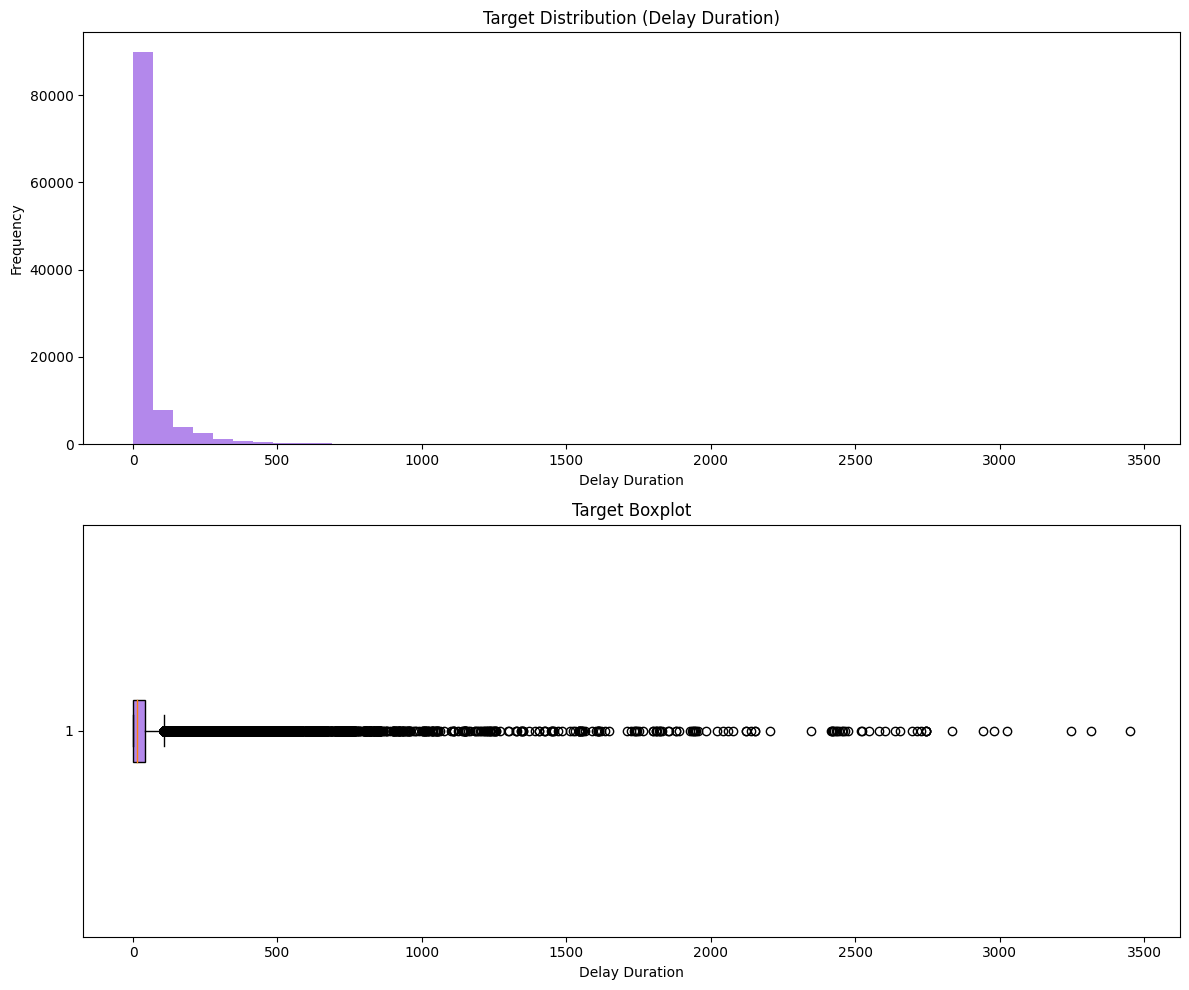

In [47]:
import matplotlib.pyplot as plt

# ----------------------------
# Target distribution and outlier inspection
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Histogram
axes[0].hist(train_df["target"], bins=50, color="#B388EB")
axes[0].set_title("Target Distribution (Delay Duration)")
axes[0].set_xlabel("Delay Duration")
axes[0].set_ylabel("Frequency")

# Boxplot
axes[1].boxplot(
    train_df["target"],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#B388EB")
)
axes[1].set_title("Target Boxplot")
axes[1].set_xlabel("Delay Duration")

plt.tight_layout()
plt.show()


The target variable (delay duration) shows a highly right-skewed distribution.
Most flights have small or zero delays, while a small number of observations have extremely large delay values.
The boxplot confirms the presence of many extreme outliers, indicating a heavy-tailed distribution.
This suggests that outlier handling or transformation may be required before modeling.

In [51]:
# ----------------------------
# Target percentile analysis
# ----------------------------

percentiles = train_df["target"].quantile([0.90, 0.95, 0.99])

percentiles_df = percentiles.reset_index()
percentiles_df.columns = ["percentile", "delay_minutes"]

#percentiles_df

# Print formatted percentile values

for p, v in percentiles.items():
    print(f"{int(p*100)}th percentile: {v:.2f} minutes")



90th percentile: 134.00 minutes
95th percentile: 226.00 minutes
99th percentile: 517.00 minutes


Based on the percentile analysis and the strong right-skewness of the target variable,
two potential strategies can be considered for handling extreme values:
(1) applying an upper cap on large delay values (for example at high percentiles),
or (2) using a logarithmic transformation of the target.
The final decision will be evaluated during the modeling phase.

#### 4.4.2 Airport Elevation

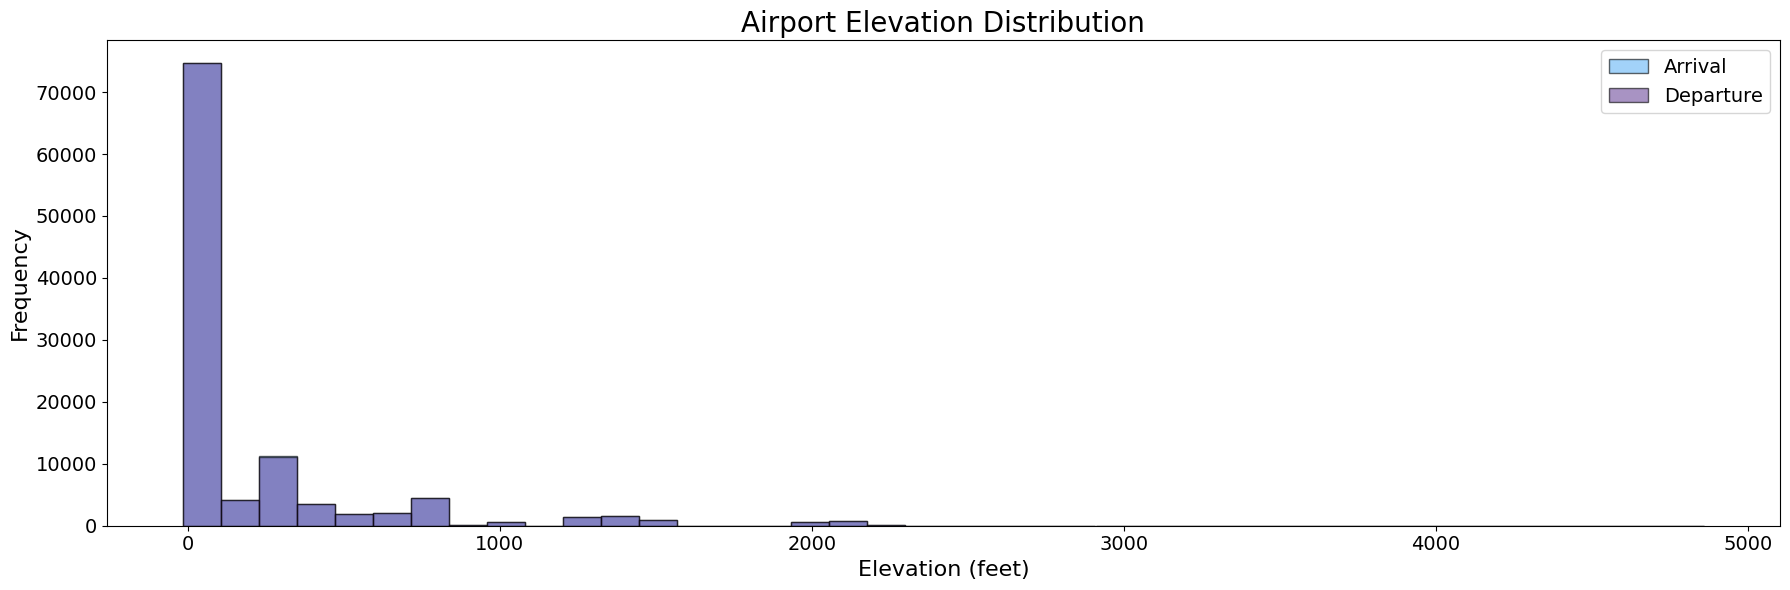

In [68]:
import matplotlib.pyplot as plt

# ----------------------------
# Airport elevation distribution (improved visibility)
# ----------------------------

plt.figure(figsize=(18, 6))

# Arrival first (background)
plt.hist(train_df["arr_elevation"], bins=40,
         label="Arrival",
         color="#64B5F6",
         alpha=0.6,
         edgecolor="black",
         zorder=1)

# Departure on top
plt.hist(train_df["dep_elevation"], bins=40,
         label="Departure",
         color="#6E4B9C",
         alpha=0.6,
         edgecolor="black",
         zorder=2)

plt.title("Airport Elevation Distribution", fontsize=20)
plt.xlabel("Elevation (feet)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


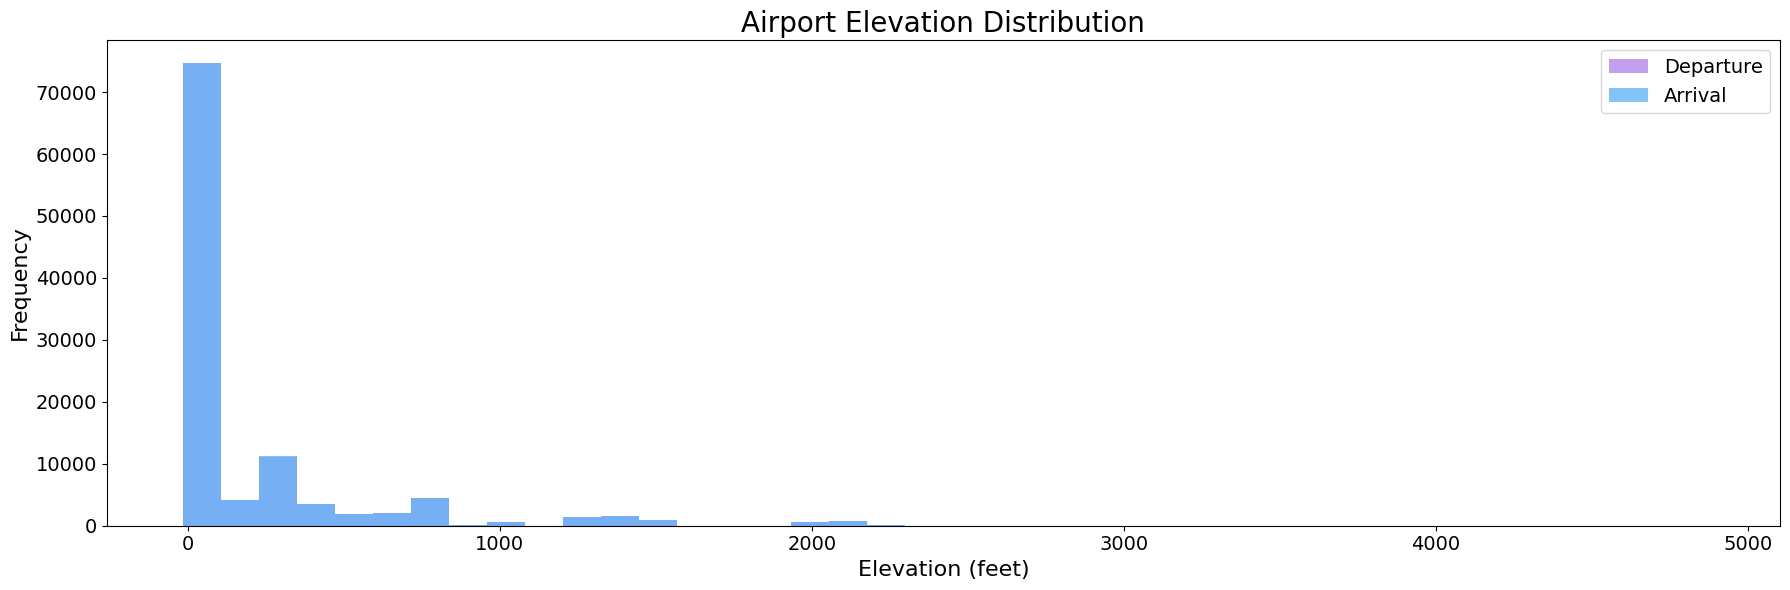

In [ ]:
import matplotlib.pyplot as plt

# ----------------------------
# Airport elevation distribution (readable version)
# ----------------------------

plt.figure(figsize=(18, 6))

plt.hist(train_df["dep_elevation"], bins=40,
         label="Departure", color="#B388EB", alpha=0.8)

plt.hist(train_df["arr_elevation"], bins=40,
         label="Arrival", color="#64B5F6", alpha=0.8)

plt.title("Airport Elevation Distribution", fontsize=20)
plt.xlabel("Elevation (feet)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

#
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


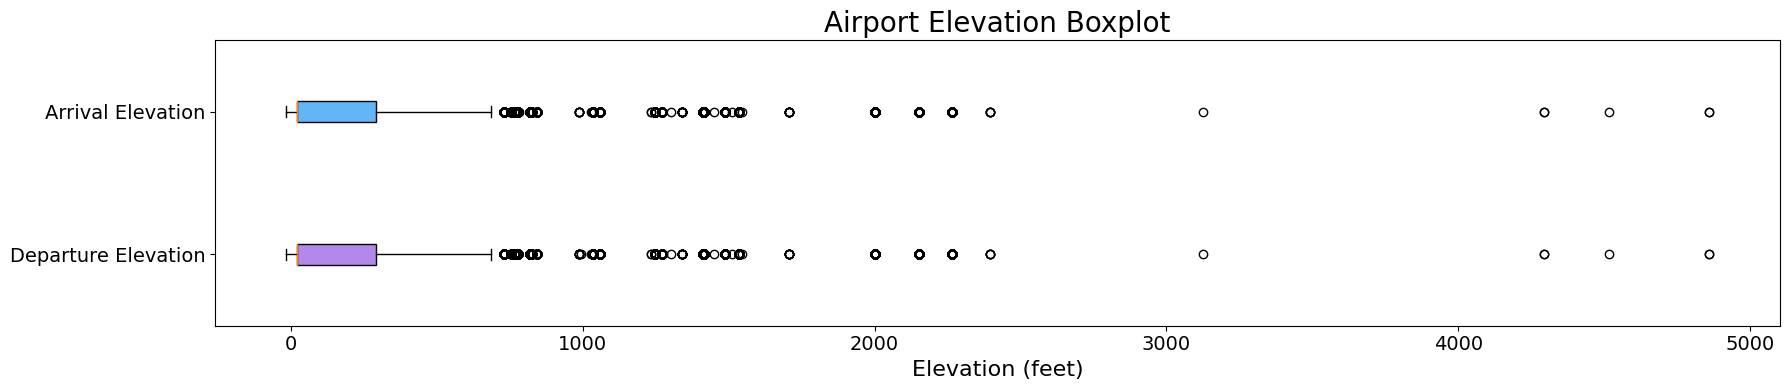

In [66]:
# ----------------------------
# Airport elevation boxplot (two-color version)
# ----------------------------

plt.figure(figsize=(18, 4))

bp = plt.boxplot(
    [train_df["dep_elevation"], train_df["arr_elevation"]],
    vert=False,
    patch_artist=True,
    labels=["Departure Elevation", "Arrival Elevation"]
)

# Set individual box colors
colors = ["#B388EB", "#64B5F6"]  # Purple = Departure, Blue = Arrival

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

plt.title("Airport Elevation Boxplot", fontsize=20)
plt.xlabel("Elevation (feet)", fontsize=16)
#plt.xlim(0, 3000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


**Observation**

Both departure and arrival airport elevations show a strongly right-skewed distribution.  
The majority of flights operate between low-altitude airports (mostly below 1000 feet),  
while a small number of airports appear at much higher elevations (above 3000–5000 feet),  
creating visible outliers in the boxplot.  

The similarity between departure and arrival elevation distributions indicates that  
flight routes in this dataset are not biased toward systematically higher or lower altitude airports.


#### 4.4.3 Geographic Coordinates

✅ Code Cell 1 — Latitude Distribution (Departure vs Arrival)

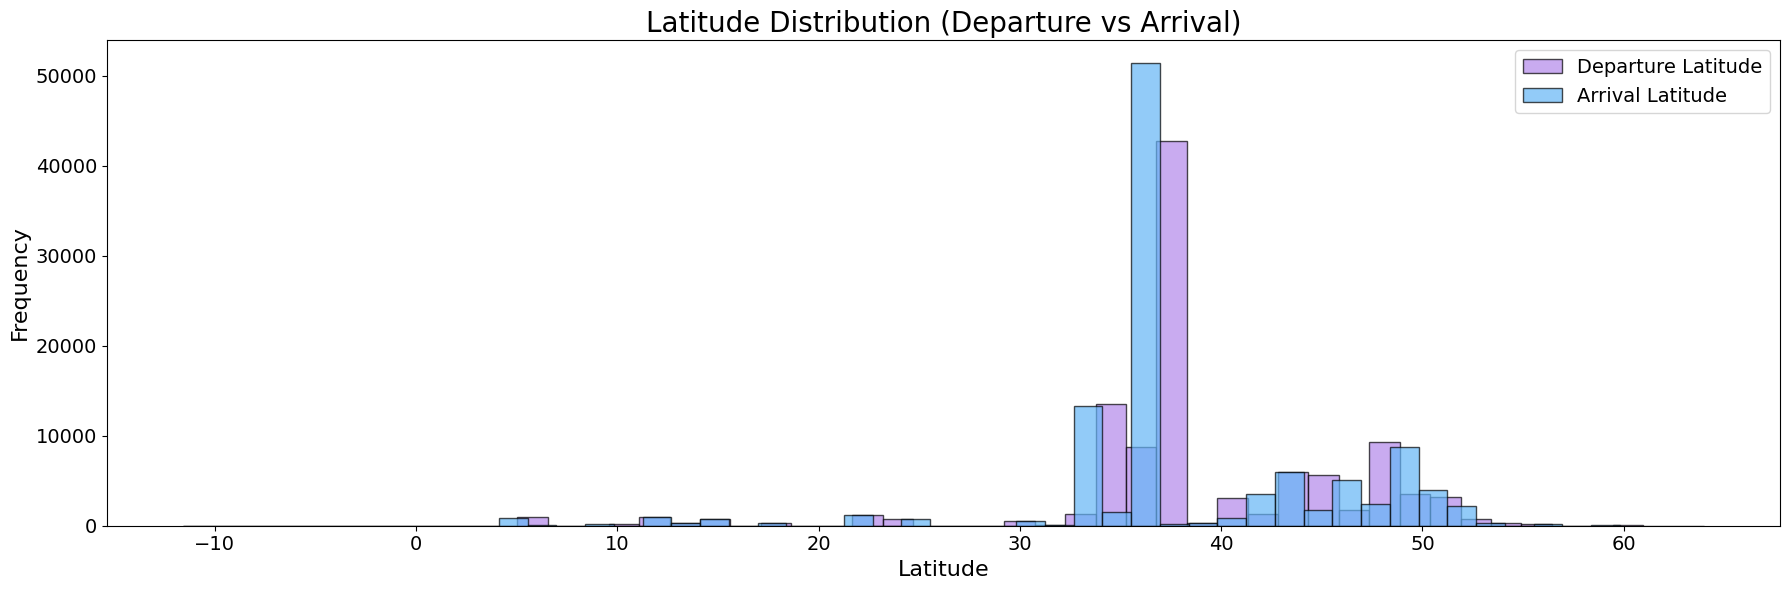

In [73]:
import matplotlib.pyplot as plt

# ----------------------------
# Latitude distribution
# ----------------------------

plt.figure(figsize=(18, 6))

plt.hist(train_df["dep_lat"], bins=50,
         label="Departure Latitude",
         color="#B388EB", alpha=0.7,
         edgecolor="black")

plt.hist(train_df["arr_lat"], bins=50,
         label="Arrival Latitude",
         color="#64B5F6", alpha=0.7,
         edgecolor="black")

plt.title("Latitude Distribution (Departure vs Arrival)", fontsize=20)
plt.xlabel("Latitude", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


✅ Code Cell 2 — Longitude Distribution (Departure vs Arrival)

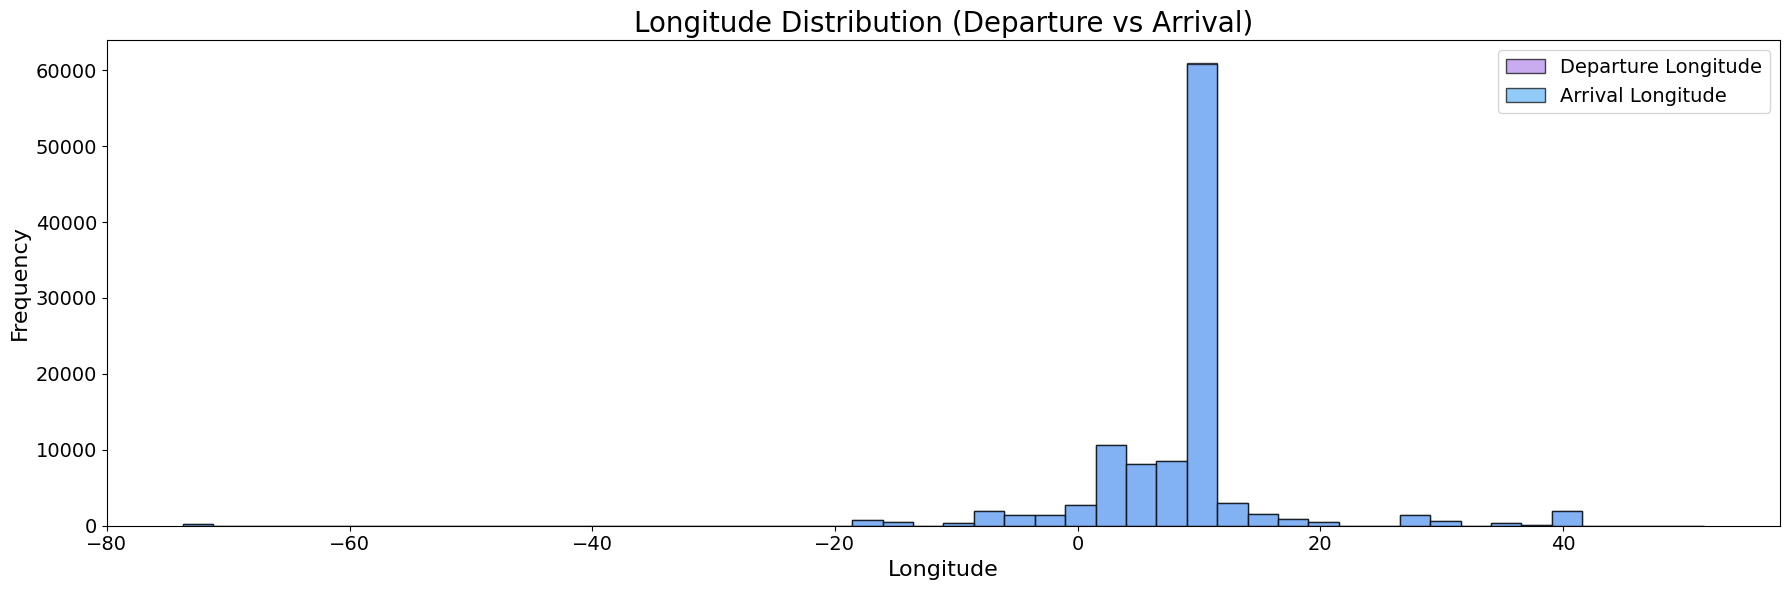

In [75]:
# ----------------------------
# Longitude distribution
# ----------------------------

plt.figure(figsize=(18, 6))

plt.hist(train_df["dep_lon"], bins=50,
         label="Departure Longitude",
         color="#B388EB", alpha=0.7,
         edgecolor="black")

plt.hist(train_df["arr_lon"], bins=50,
         label="Arrival Longitude",
         color="#64B5F6", alpha=0.7,
         edgecolor="black")

plt.title("Longitude Distribution (Departure vs Arrival)", fontsize=20)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


**Observation**

Both departure and arrival latitude distributions are highly concentrated between approximately 30° and 55°, indicating that most flights operate within mid-latitude regions, primarily covering Europe and surrounding areas.  
Longitude values are mainly clustered between approximately -10° and 20°, with smaller secondary clusters extending toward eastern and western longitudes.  
The strong overlap between departure and arrival coordinate distributions suggests similar geographic coverage for origin and destination airports.  
No invalid coordinate ranges are observed (latitude remains within [-90, 90] and longitude within [-180, 180]), indicating that the geographic data is physically consistent.

This geographic concentration is consistent with the operational network of Tunisair, which mainly serves regional and short-to-medium haul routes connecting Tunisia with nearby European and Mediterranean destinations.  
Therefore, the dataset is geographically aligned with the target application domain of the challenge and is suitable for learning location-dependent delay patterns relevant to Tunisair operations.


#### 4.4.4 Time-Based Features

##### - Hour of Day Distribution (Departure vs Arrival)


In [ ]:

# ----------------------------
# Convert STD to datetime and extract departure hour
# ----------------------------

train_df["STD_dt"] = pd.to_datetime(train_df["STD"], errors="coerce")
train_df["dep_hour"] = train_df["STD_dt"].dt.hour

train_df[["STD", "dep_hour"]].head()


,STD,dep_hour
0,2016-01-03 10:30:00,10
1,2016-01-13 15:05:00,15
2,2016-01-16 04:10:00,4
3,2016-01-17 14:10:00,14
4,2016-01-17 14:30:00,14


In [88]:
# ----------------------------
# Convert STA to datetime and extract arrival hour
# ----------------------------

train_df["STA_dt"] = pd.to_datetime(
    train_df["STA"],
    format="%Y-%m-%d %H.%M.%S",
    errors="coerce"
)

train_df["arr_hour"] = train_df["STA_dt"].dt.hour

train_df[["STA", "arr_hour"]].head()


,STA,arr_hour
0,2016-01-03 12.55.00,12
1,2016-01-13 16.55.00,16
2,2016-01-16 06.45.00,6
3,2016-01-17 17.00.00,17
4,2016-01-17 15.50.00,15


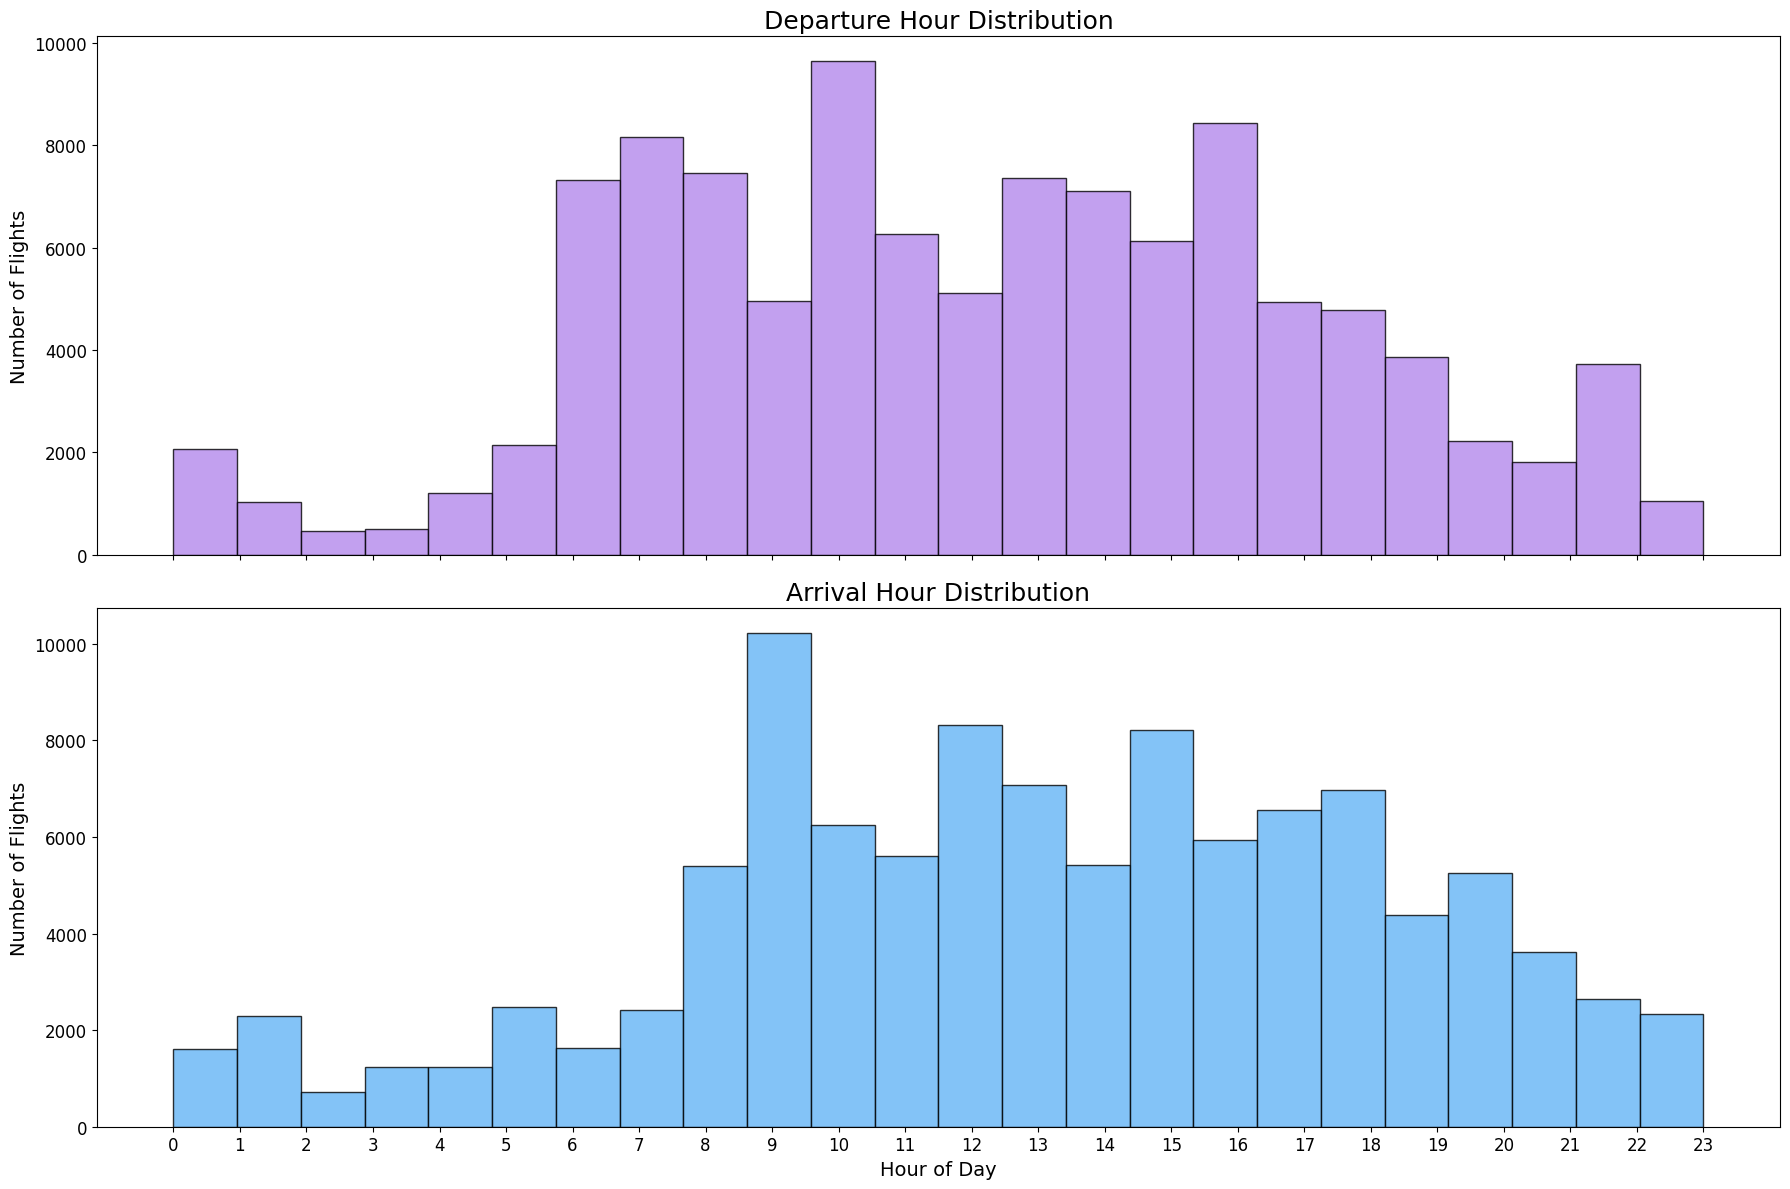

In [92]:
import matplotlib.pyplot as plt

# ----------------------------
# Hour of day distribution (Departure vs Arrival)
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Departure hour
axes[0].hist(
    train_df["dep_hour"],
    bins=24,
    color="#B388EB",
    alpha=0.8,
    edgecolor="black"
)

axes[0].set_title("Departure Hour Distribution", fontsize=18)
axes[0].set_ylabel("Number of Flights", fontsize=14)
axes[0].tick_params(axis="y", labelsize=12)

# Arrival hour
axes[1].hist(
    train_df["arr_hour"],
    bins=24,
    color="#64B5F6",
    alpha=0.8,
    edgecolor="black"
)

axes[1].set_title("Arrival Hour Distribution", fontsize=18)
axes[1].set_xlabel("Hour of Day", fontsize=14)
axes[1].set_ylabel("Number of Flights", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)

plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


**Observation**

Both departure and arrival flights show strong concentration during daytime operational hours, with clear peaks in the morning and afternoon periods.
Most flights are scheduled during daytime hours.
Departure and arrival activity peaks in the morning (around 7–10) and again in the afternoon (around 14–17).
Very few flights operate during late night and early morning hours (0–5), indicating limited overnight operations.
This pattern reflects typical airline scheduling behavior and indicates that time-of-day may be an important temporal feature for modeling delay dynamics.

##### - Day of Week Distribution (Departure vs Arrival)

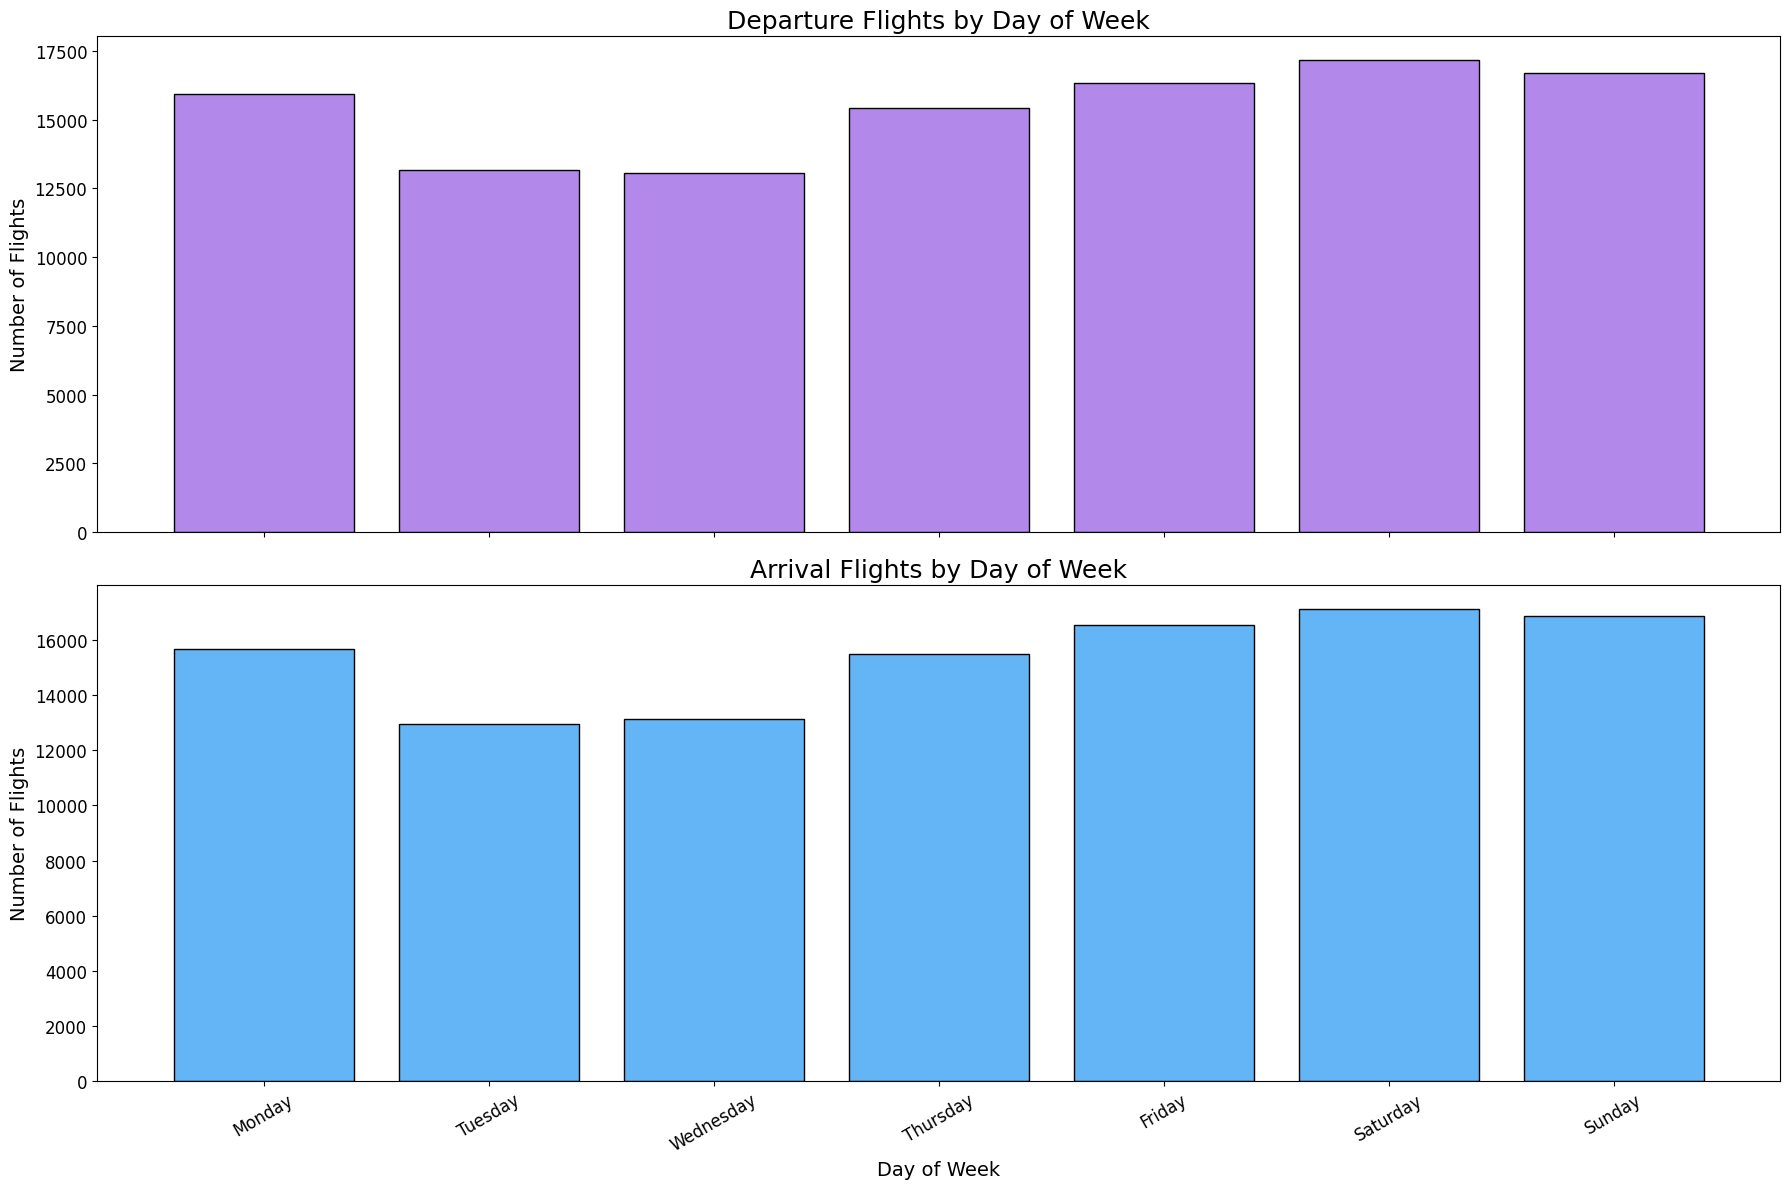

In [93]:
# ----------------------------
# Extract day of week for departure (DATOP) and arrival (STA)
# ----------------------------

# DATOP uses standard format
train_df["DATOP_dt"] = pd.to_datetime(train_df["DATOP"], errors="coerce")

# STA uses dot-separated time format
train_df["STA_dt_tmp"] = pd.to_datetime(
    train_df["STA"],
    format="%Y-%m-%d %H.%M.%S",
    errors="coerce"
)

train_df["dep_day"] = train_df["DATOP_dt"].dt.day_name()
train_df["arr_day"] = train_df["STA_dt_tmp"].dt.day_name()

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday",
             "Friday", "Saturday", "Sunday"]

dep_counts = train_df["dep_day"].value_counts().reindex(day_order)
arr_counts = train_df["arr_day"].value_counts().reindex(day_order)

# ----------------------------
# Plot subplots
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Departure
axes[0].bar(day_order, dep_counts, color="#B388EB", edgecolor="black")
axes[0].set_title("Departure Flights by Day of Week", fontsize=18)
axes[0].set_ylabel("Number of Flights", fontsize=14)
axes[0].tick_params(axis="y", labelsize=12)

# Arrival
axes[1].bar(day_order, arr_counts, color="#64B5F6", edgecolor="black")
axes[1].set_title("Arrival Flights by Day of Week", fontsize=18)
axes[1].set_xlabel("Day of Week", fontsize=14)
axes[1].set_ylabel("Number of Flights", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


**Observation**

Flight volume is relatively stable across the week, with slightly lower activity on Tuesday and Wednesday.
The highest number of both departures and arrivals occurs during the weekend, especially on Saturday and Sunday, indicating increased travel demand toward the end of the week.

##### - Monthly Distribution (Departure vs Arrival)


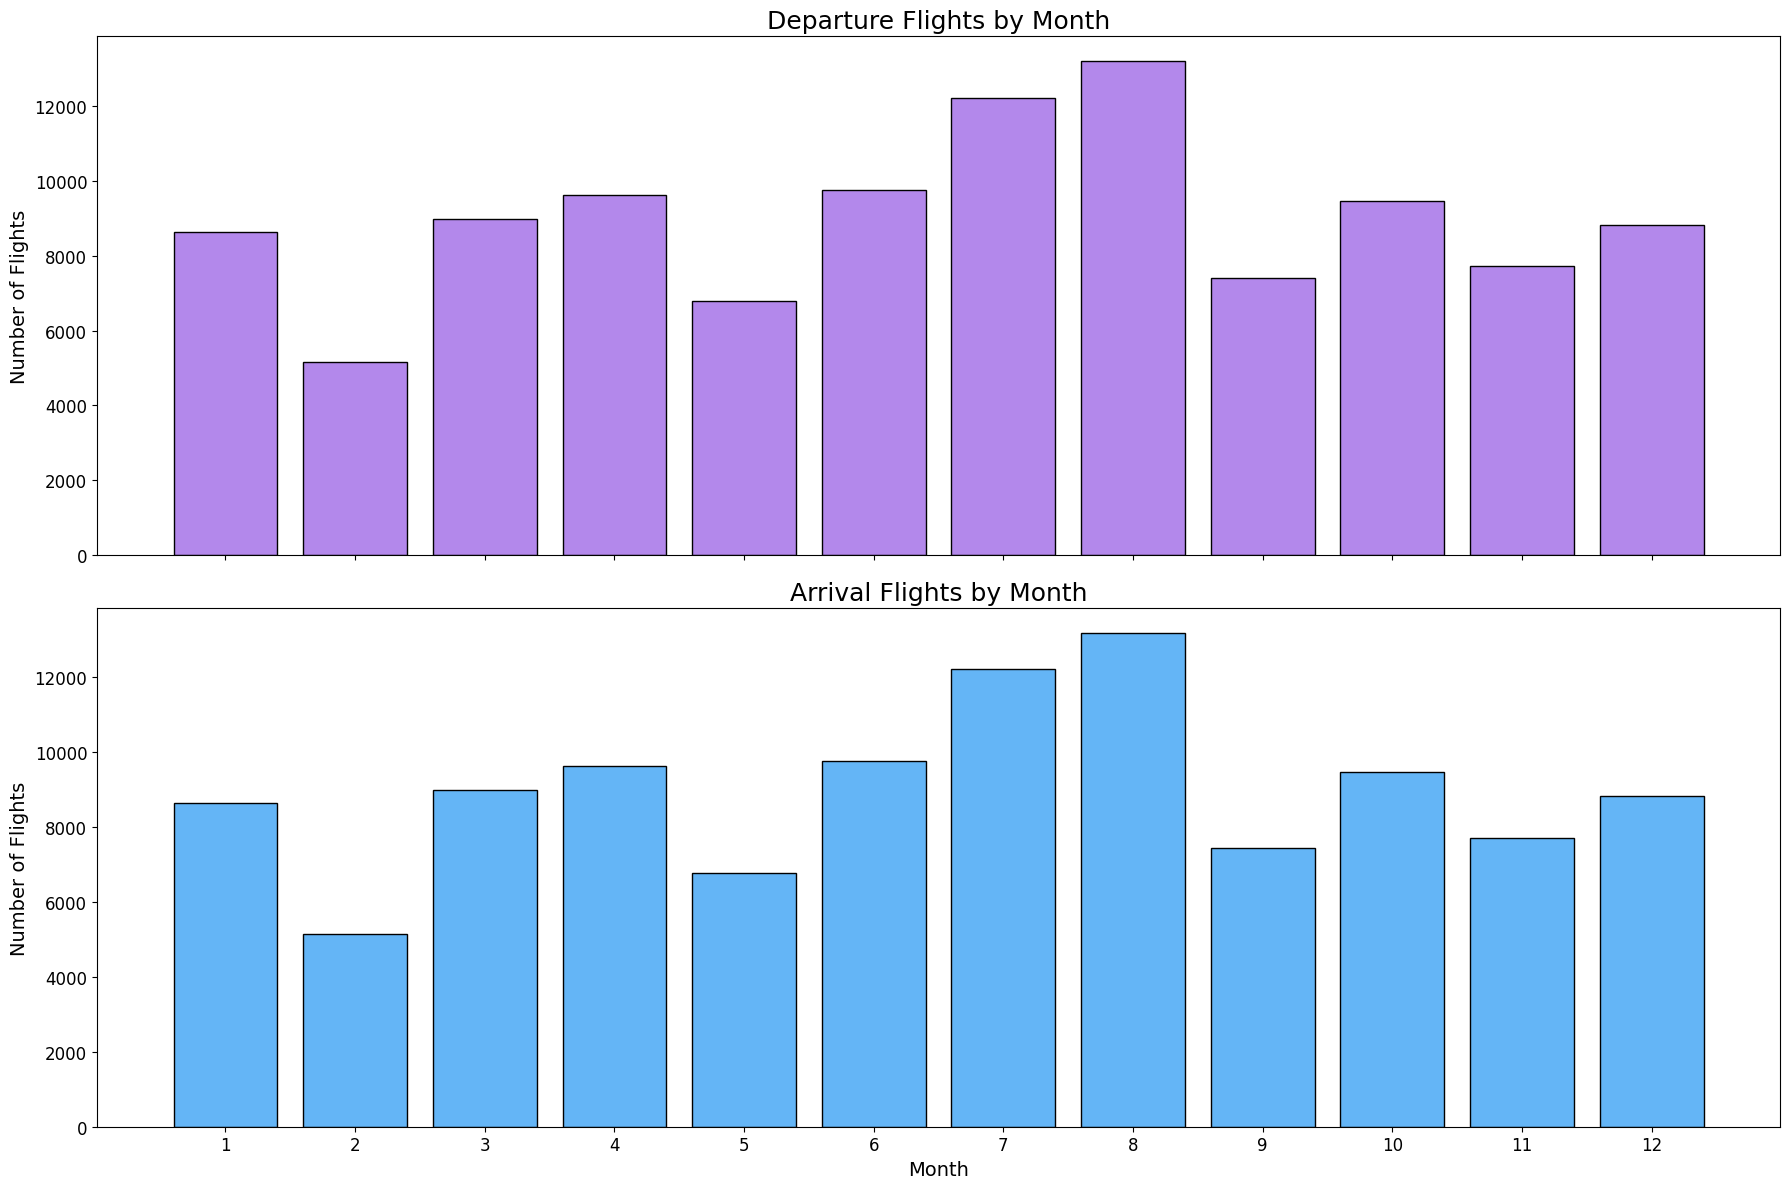

In [94]:

# ----------------------------
# Extract month for departure (DATOP)
# ----------------------------

train_df["DATOP_dt"] = pd.to_datetime(
    train_df["DATOP"],
    errors="coerce"
)

train_df["dep_month"] = train_df["DATOP_dt"].dt.month

# ----------------------------
# Extract month for arrival (STA)
# ----------------------------

train_df["STA_dt_tmp"] = pd.to_datetime(
    train_df["STA"],
    format="%Y-%m-%d %H.%M.%S",
    errors="coerce"
)

train_df["arr_month"] = train_df["STA_dt_tmp"].dt.month

# ----------------------------
# Count monthly frequencies
# ----------------------------

dep_month_counts = train_df["dep_month"].value_counts().sort_index()
arr_month_counts = train_df["arr_month"].value_counts().sort_index()

months = range(1, 13)

# ----------------------------
# Plot subplots
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Departure
axes[0].bar(months, dep_month_counts, color="#B388EB", edgecolor="black")
axes[0].set_title("Departure Flights by Month", fontsize=18)
axes[0].set_ylabel("Number of Flights", fontsize=14)
axes[0].tick_params(axis="y", labelsize=12)

# Arrival
axes[1].bar(months, arr_month_counts, color="#64B5F6", edgecolor="black")
axes[1].set_title("Arrival Flights by Month", fontsize=18)
axes[1].set_xlabel("Month", fontsize=14)
axes[1].set_ylabel("Number of Flights", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)

plt.xticks(months)
plt.tight_layout()
plt.show()


### 4.5 Distribution Analysis (Categorical Features)